In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import torch
import torch.nn.functional as F
from torch import Tensor
from sentence_transformers import SentenceTransformer

#########################################
# Load model
#########################################

print("\n\n### Loading EmbeddingGemma model ###")
model = SentenceTransformer("google/embeddinggemma-300m")

# Get the underlying components for custom approaches
tokenizer = None
base_transformer = None
dense_layers = []

for i, module in enumerate(model):
    print(f"  Layer {i}: {type(module).__name__}")
    if hasattr(module, 'tokenizer'):
        tokenizer = module.tokenizer
    if hasattr(module, 'auto_model'):
        base_transformer = module.auto_model
    # Collect Dense layers (there are 2 in EmbeddingGemma)
    if type(module).__name__ == 'Dense':
        dense_layers.append(module)

if tokenizer is None:
    raise ValueError("Could not find tokenizer in model modules")
if base_transformer is None:
    raise ValueError("Could not find base transformer in model modules")

print(f"\nLoaded model with tokenizer: {type(tokenizer).__name__}")
print(f"Base transformer: {type(base_transformer).__name__}")
print(f"Found {len(dense_layers)} Dense projection layers")








### Loading EmbeddingGemma model ###


modules.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

c:\code\embedding-experiments\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ms\.cache\huggingface\hub\models--google--embeddinggemma-300m. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/312 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

  Layer 0: Transformer
  Layer 1: Pooling
  Layer 2: Dense
  Layer 3: Dense
  Layer 4: Normalize

Loaded model with tokenizer: GemmaTokenizerFast
Base transformer: Gemma3TextModel
Found 2 Dense projection layers


In [6]:


#########################################
# Helper: masked average pooling
#########################################

def masked_average_pool(last_hidden_states: Tensor,
                        pooling_mask: Tensor,
                        label: str = "") -> Tensor:
    """
    last_hidden_states: [batch, seq_len, hidden_dim]
    pooling_mask:       [batch, seq_len] with 1 for tokens to include, 0 otherwise
    label:              optional label for logging
    """
    batch_size, seq_len, hidden_dim = last_hidden_states.shape
    
    if label:
        print(f"\n[{label}] Pooling Operation:")
        print(f"  Input shape: {last_hidden_states.shape}")
        print(f"  Pooling mask shape: {pooling_mask.shape}")
    
    # Expand mask to [batch, seq_len, 1]
    mask = pooling_mask[..., None].bool()

    # Zero-out tokens we don't want to pool over
    masked_hidden = last_hidden_states.masked_fill(~mask, 0.0)

    # Sum over tokens
    summed = masked_hidden.sum(dim=1)

    # Count how many tokens are actually included per example
    counts = pooling_mask.sum(dim=1)[..., None].clamp(min=1)
    
    if label:
        for i in range(min(batch_size, 3)):  # Show first 3 examples
            num_tokens = int(counts[i, 0].item())
            total_seq_len = (pooling_mask[i] != 0).sum().item()
            print(f"  Batch {i}: pooling over {num_tokens}/{seq_len} tokens")
            if total_seq_len < seq_len:
                print(f"    (sequence padded from {total_seq_len} to {seq_len})")

    # Return average
    result = summed / counts
    
    if label:
        print(f"  Output shape: {result.shape}")
    
    return result


#########################################
# Build inputs with explicit context for custom approach
#########################################

def build_inputs_with_context_custom(contexts, texts, tokenizer):
    """
    Build custom inputs where context is in attention but not in pooling.
    
    contexts: list[str]  -- extra context for each example
    texts:    list[str]  -- main text we want to embed

    Returns:
      batch_dict      -- dict with input_ids, attention_mask for the model
      pooling_mask    -- tensor [batch, seq_len], 1 only on "text" tokens
    """
    bos_id = tokenizer.bos_token_id
    eos_id = tokenizer.eos_token_id

    input_ids = []
    attention_masks = []
    pooling_masks = []

    for ctx, txt in zip(contexts, texts):
        # Tokenize WITHOUT special tokens so we can control layout
        ctx_ids = tokenizer.encode(ctx, add_special_tokens=False)
        txt_ids = tokenizer.encode(txt, add_special_tokens=False)

        # Layout: [BOS] context [EOS] text [EOS]
        ids = [bos_id] + ctx_ids + [eos_id] + txt_ids + [eos_id]

        # Model attention mask: attend to everything except padding
        attn = [1] * len(ids)

        # Pooling mask:
        #   0 for [BOS], context, and first [EOS]
        #   1 for text tokens
        #   0 for final [EOS]
        num_ctx = len(ctx_ids)
        num_txt = len(txt_ids)

        pool = (
            [0] * (1 + num_ctx + 1) +  # [BOS] + context + [EOS]
            [1] * num_txt +            # text tokens
            [0]                        # final [EOS]
        )

        input_ids.append(ids)
        attention_masks.append(attn)
        pooling_masks.append(pool)

    # Pad sequences to same length for batching
    batch = tokenizer.pad(
        {"input_ids": input_ids, "attention_mask": attention_masks},
        padding=True,
        return_tensors="pt",
    )

    # Pad the pooling masks with 0
    pooling_masks = tokenizer.pad(
        {"input_ids": pooling_masks},
        padding=True,
        return_tensors="pt",
    )["input_ids"]

    return batch, pooling_masks


def apply_dense_layers(embeddings: Tensor, dense_layers: list) -> Tensor:
    """
    Apply Dense projection layers to embeddings.
    EmbeddingGemma has 2 Dense layers after pooling.
    """
    with torch.no_grad():
        features = {"sentence_embedding": embeddings}
        for dense in dense_layers:
            features = dense(features)
        # Clone to avoid inference mode issues
        return features["sentence_embedding"].clone()


def compute_and_print_scores(query_embedding: Tensor, 
                              passage_embeddings: Tensor,
                              approach_name: str) -> Tensor:
    """
    Compute similarity scores and print top 3 results.
    Returns the scores tensor and top indices.
    """
    # Ensure query_embedding is 2D
    if query_embedding.dim() == 1:
        query_embedding = query_embedding.unsqueeze(0)
    
    scores = (query_embedding @ passage_embeddings.T) * 100
    print(f"\n{approach_name} - Similarity scores (top 3):")
    top_indices = scores[0].argsort(descending=True)[:3]
    for idx in top_indices:
        print(f"  Query vs Passage {idx.item() + 1}: {scores[0, idx].item():.2f}")
    return scores, top_indices


In [11]:

#########################################
# Example data - CONTRIVED SCENARIO
#########################################



# Define multiple test scenarios as an array of (context, query) pairs
test_scenarios = [
    # Scenario 1: misleading query, validates that attention from context prevents being misled
    {
        "context": "My favorite woman in history is Marie Curie",
        "query": "What is she known for? I think she's most known for being a pharooh, but I'm not sure."
    },
    # Scenario 2: Some irrelevant information in context
    {
        "context": "My favorite pharaoh is tutenkhamun.  My favorite woman in history is Marie Curie.",
        "query": "What is my she known for?"
    },
    # Scenario 3: Confusing context, shows that attention helps disambiguate without overly influencing the core meaning of the query; 
    # also tests for recency bias issues in context influence by ending with an irrelevant but misleading fact
    {
        "context": "My favorite pharaoh is tutenkhamun. Amelia Earhart was known for her solo flights.  Cleopatra was a pharaoh. My favorite woman in history is Marie Curie. Marie Antoinette was a famous Queen of France.",
        "query": "What is my favorite woman in history most known for?"
    }
]


passages = [
    "Marie Antoinette is most known for being the last Queen of France before the French Revolution and her alleged quote 'Let them eat cake'.",
    "Cleopatra is most known for being the last pharaoh of Ancient Egypt and her relationships with Julius Caesar and Mark Antony.",
    "Joan of Arc is most known for leading the French army against English occupation during the Hundred Years' War.",
    "Rosa Parks is most known for refusing to give up her bus seat to a white passenger, sparking the Montgomery Bus Boycott.",
    "Marie Curie is most known for being the first woman to win a Nobel Prize and discovering the elements polonium and radium.",
    "Frida Kahlo is most known for her self-portraits and paintings that explored identity, postcolonialism, and the female experience.",
    "Virginia Woolf is most known for her modernist novels like Mrs. Dalloway and To the Lighthouse.",
    "Eleanor Roosevelt is most known for her role in drafting the Universal Declaration of Human Rights and her advocacy for civil rights.",
    "Amelia Earhart is most known for being the first female aviator to fly solo across the Atlantic Ocean.",
]


# Print the scenarios and passages
print("Test Scenarios:")
for i, scenario in enumerate(test_scenarios):
    print(f"\nScenario {i+1}:")
    print(f"  Context: {scenario['context']}")
    print(f"  Query: {scenario['query']}")

print("\nPassages:")
for i, passage in enumerate(passages):
    print(f"  {i+1}. {passage}")


Test Scenarios:

Scenario 1:
  Context: My favorite woman in history is Marie Curie
  Query: What is she known for? I think she's most known for being a pharooh, but I'm not sure.

Scenario 2:
  Context: My favorite pharaoh is tutenkhamun.  My favorite woman in history is Marie Curie.
  Query: What is my she known for?

Scenario 3:
  Context: My favorite pharaoh is tutenkhamun. Amelia Earhart was known for her solo flights.  Cleopatra was a pharaoh. My favorite woman in history is Marie Curie. Marie Antoinette was a famous Queen of France.
  Query: What is my favorite woman in history most known for?

Passages:
  1. Marie Antoinette is most known for being the last Queen of France before the French Revolution and her alleged quote 'Let them eat cake'.
  2. Cleopatra is most known for being the last pharaoh of Ancient Egypt and her relationships with Julius Caesar and Mark Antony.
  3. Joan of Arc is most known for leading the French army against English occupation during the Hundred Ye

In [12]:
#########################################
# Compute passage embeddings ONCE (used by all approaches)
#########################################
print("\n\n### Computing passage embeddings (once) ###")

# Use the standard encode_document method - already normalized
passage_embeddings = model.encode_document(passages, convert_to_tensor=True)
print(f"Computed {len(passages)} passage embeddings with shape {passage_embeddings.shape}")

# Get device
device = base_transformer.device

# Store results for all scenarios
all_scenario_results = []

#########################################
# Loop through all test scenarios
#########################################
for scenario_idx, scenario in enumerate(test_scenarios):
    context = scenario["context"]
    query = scenario["query"]
    
    print(f"\n\n{'='*80}")
    print(f"### SCENARIO {scenario_idx + 1} ###")
    print(f"Context: {context}")
    print(f"Query: {query}")
    print('='*80)

    #########################################
    # APPROACH 1: Context in attention, NOT in pooling (CORE EXPERIMENT)
    #########################################
    print("\n### APPROACH 1: Context in attention only (custom masked pooling) ###")

    # Add the standard EmbeddingGemma query prompt to the query text only
    query_prompt = "task: search result | query: "
    query_with_prompt = f"{query_prompt}{query}"

    # Build custom inputs with context in attention but not in pooling
    batch, pooling_mask = build_inputs_with_context_custom(
        contexts=[context],
        texts=[query_with_prompt],
        tokenizer=tokenizer,
    )

    # Move to device
    batch = {k: v.to(device) for k, v in batch.items()}
    pooling_mask = pooling_mask.to(device)

    with torch.no_grad():
        outputs = base_transformer(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        )

    last_hidden = outputs.last_hidden_state
    query_embedding = masked_average_pool(last_hidden, pooling_mask, label="Approach 1 - Query")
    query_embedding = apply_dense_layers(query_embedding, dense_layers)
    query_embedding = F.normalize(query_embedding, p=2, dim=1)

    scores, top_indices = compute_and_print_scores(query_embedding, passage_embeddings, "Approach 1")

    #########################################
    # APPROACH 2: NO context at all (baseline)
    #########################################
    print("\n### APPROACH 2: No context (baseline) ###")

    query_with_prompt = f"{query_prompt}{query}"
    query_no_context_batch = tokenizer([query_with_prompt], padding=True, return_tensors="pt")
    query_no_context_batch = {k: v.to(device) for k, v in query_no_context_batch.items()}

    with torch.no_grad():
        query_no_context_outputs = base_transformer(**query_no_context_batch)

    query_embedding_nc = masked_average_pool(
        query_no_context_outputs.last_hidden_state,
        query_no_context_batch["attention_mask"],
        label="Approach 2 - Query"
    )
    query_embedding_nc = apply_dense_layers(query_embedding_nc, dense_layers)
    query_embedding_nc = F.normalize(query_embedding_nc, p=2, dim=1)

    scores_nc, top_indices_nc = compute_and_print_scores(query_embedding_nc, passage_embeddings, "Approach 2")

    #########################################
    # APPROACH 3: Context included in embedding
    #########################################
    print("\n### APPROACH 3: Context included in the embedding ###")

    query_with_context = f"{context} {query_prompt}{query}"
    query_context_batch = tokenizer([query_with_context], padding=True, return_tensors="pt")
    query_context_batch = {k: v.to(device) for k, v in query_context_batch.items()}

    with torch.no_grad():
        query_context_outputs = base_transformer(**query_context_batch)

    query_embedding_emb = masked_average_pool(
        query_context_outputs.last_hidden_state,
        query_context_batch["attention_mask"],
        label="Approach 3 - Query"
    )
    query_embedding_emb = apply_dense_layers(query_embedding_emb, dense_layers)
    query_embedding_emb = F.normalize(query_embedding_emb, p=2, dim=1)

    scores_emb, top_indices_emb = compute_and_print_scores(query_embedding_emb, passage_embeddings, "Approach 3")

    #########################################
    # APPROACH 4: Standard EmbeddingGemma (for comparison)
    #########################################
    print("\n### APPROACH 4: Standard EmbeddingGemma encode_query method ###")

    query_embedding_standard = model.encode_query(query, convert_to_tensor=True)
    similarities = model.similarity(query_embedding_standard, passage_embeddings) * 100

    print(f"\nApproach 4 - Similarity scores (top 3):")
    top_indices_standard = similarities[0].argsort(descending=True)[:3]
    for idx in top_indices_standard:
        print(f"  Query vs Passage {idx.item() + 1}: {similarities[0, idx].item():.2f}")

    # Verification
    print(f"\nVerification: Approach 4 vs Approach 2")
    manual_sim = (query_embedding_nc @ passage_embeddings.T) * 100
    print(f"  Max difference in scores: {(similarities - manual_sim).abs().max().item():.6f}")
    print(f"  Embeddings identical: {torch.allclose(query_embedding_standard, query_embedding_nc, atol=1e-6)}")
    
    # Store results for this scenario
    all_scenario_results.append({
        'scenario_idx': scenario_idx,
        'context': context,
        'query': query,
        'scores': {
            'Approach 1: Context in Attention Only': scores[0].cpu().numpy(),
            'Approach 2: No Context (Baseline)': scores_nc[0].cpu().numpy(),
            'Approach 3: Context in Embedding': scores_emb[0].cpu().numpy(),
            'Approach 4: Standard EmbeddingGemma': similarities[0].cpu().numpy()
        }
    })

print(f"\n\nCompleted analysis for all {len(test_scenarios)} scenarios!")




### Computing passage embeddings (once) ###
Computed 9 passage embeddings with shape torch.Size([9, 768])


### SCENARIO 1 ###
Context: My favorite woman in history is Marie Curie
Query: What is she known for? I think she's most known for being a pharooh, but I'm not sure.

### APPROACH 1: Context in attention only (custom masked pooling) ###

[Approach 1 - Query] Pooling Operation:
  Input shape: torch.Size([1, 45, 768])
  Pooling mask shape: torch.Size([1, 45])
  Batch 0: pooling over 34/45 tokens
    (sequence padded from 34 to 45)
  Output shape: torch.Size([1, 768])

Approach 1 - Similarity scores (top 3):
  Query vs Passage 5: 51.94
  Query vs Passage 2: 40.21
  Query vs Passage 3: 36.06

### APPROACH 2: No context (baseline) ###

[Approach 2 - Query] Pooling Operation:
  Input shape: torch.Size([1, 36, 768])
  Pooling mask shape: torch.Size([1, 36])
  Batch 0: pooling over 36/36 tokens
  Output shape: torch.Size([1, 768])
Computed 9 passage embeddings with shape torch.Size([9,



### Visualizing Results for All Scenarios ###


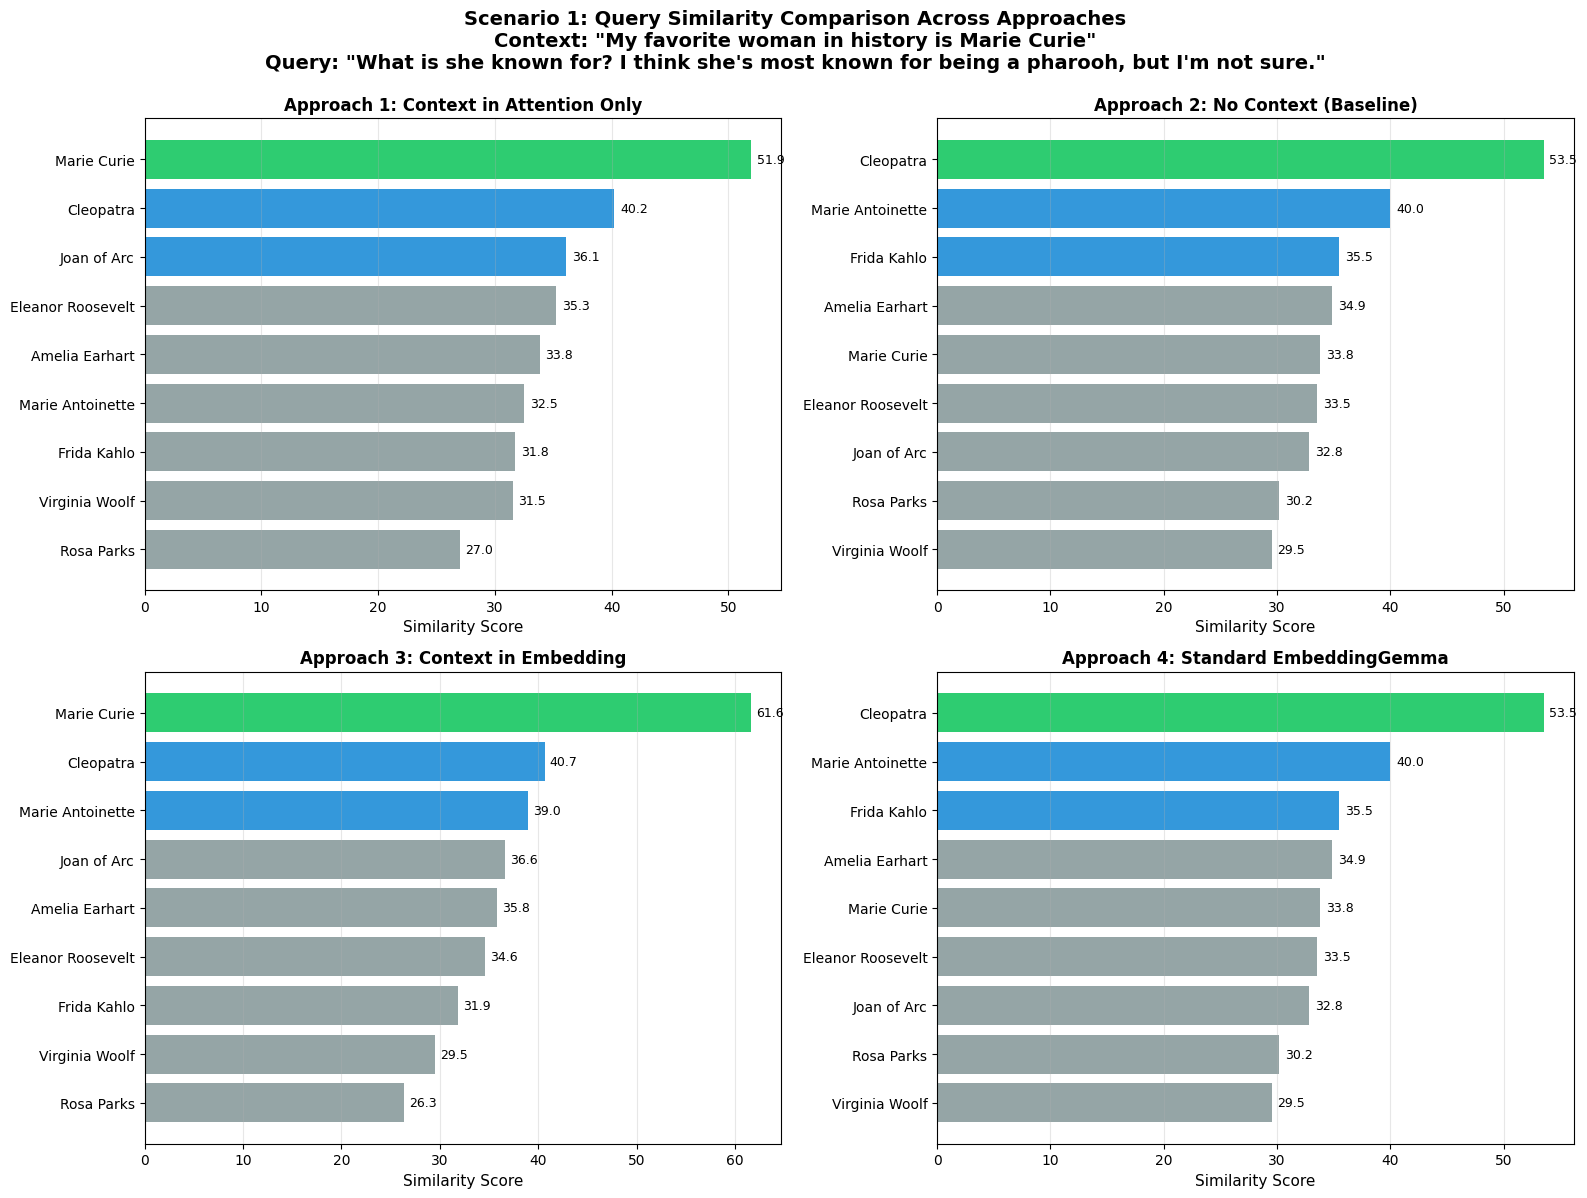


### Scenario 1: Top Match for Each Approach ###
Approach 1: Context in Attention Only:
  Winner: Marie Curie (score: 51.94)
Approach 2: No Context (Baseline):
  Winner: Cleopatra (score: 53.51)
Approach 3: Context in Embedding:
  Winner: Marie Curie (score: 61.61)
Approach 4: Standard EmbeddingGemma:
  Winner: Cleopatra (score: 53.51)



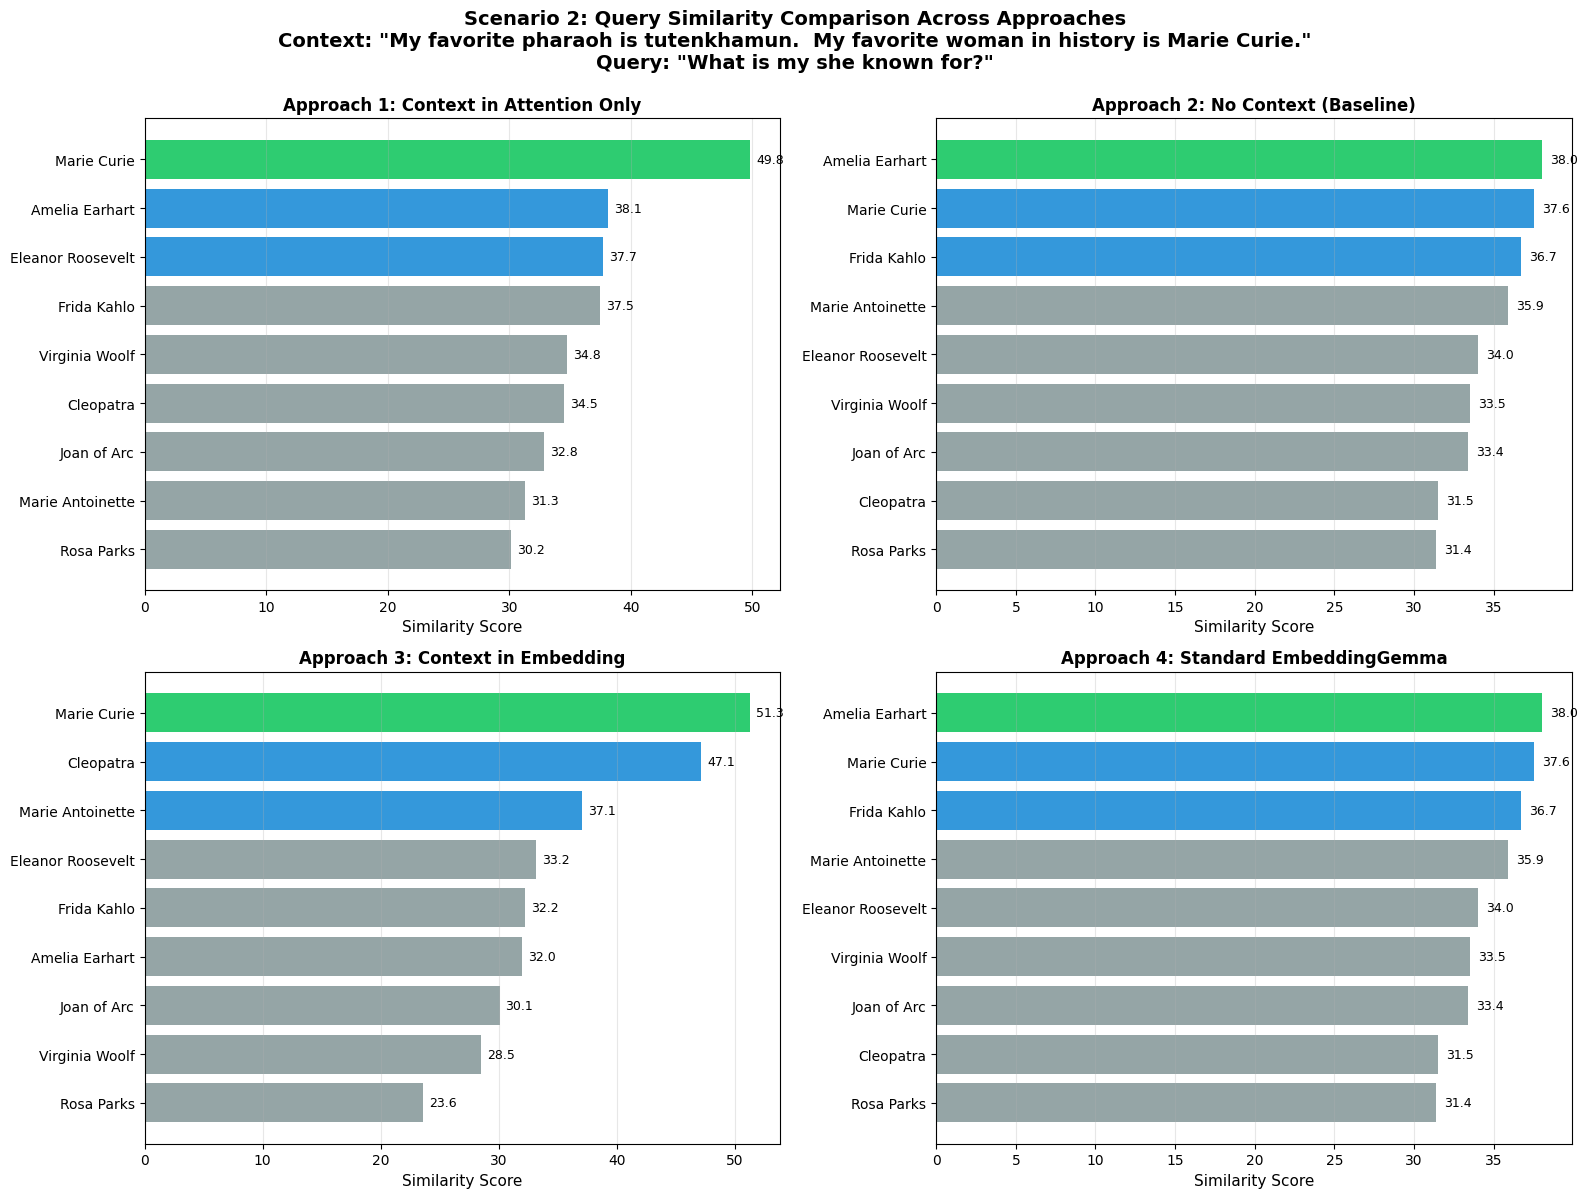


### Scenario 2: Top Match for Each Approach ###
Approach 1: Context in Attention Only:
  Winner: Marie Curie (score: 49.82)
Approach 2: No Context (Baseline):
  Winner: Amelia Earhart (score: 38.02)
Approach 3: Context in Embedding:
  Winner: Marie Curie (score: 51.29)
Approach 4: Standard EmbeddingGemma:
  Winner: Amelia Earhart (score: 38.02)



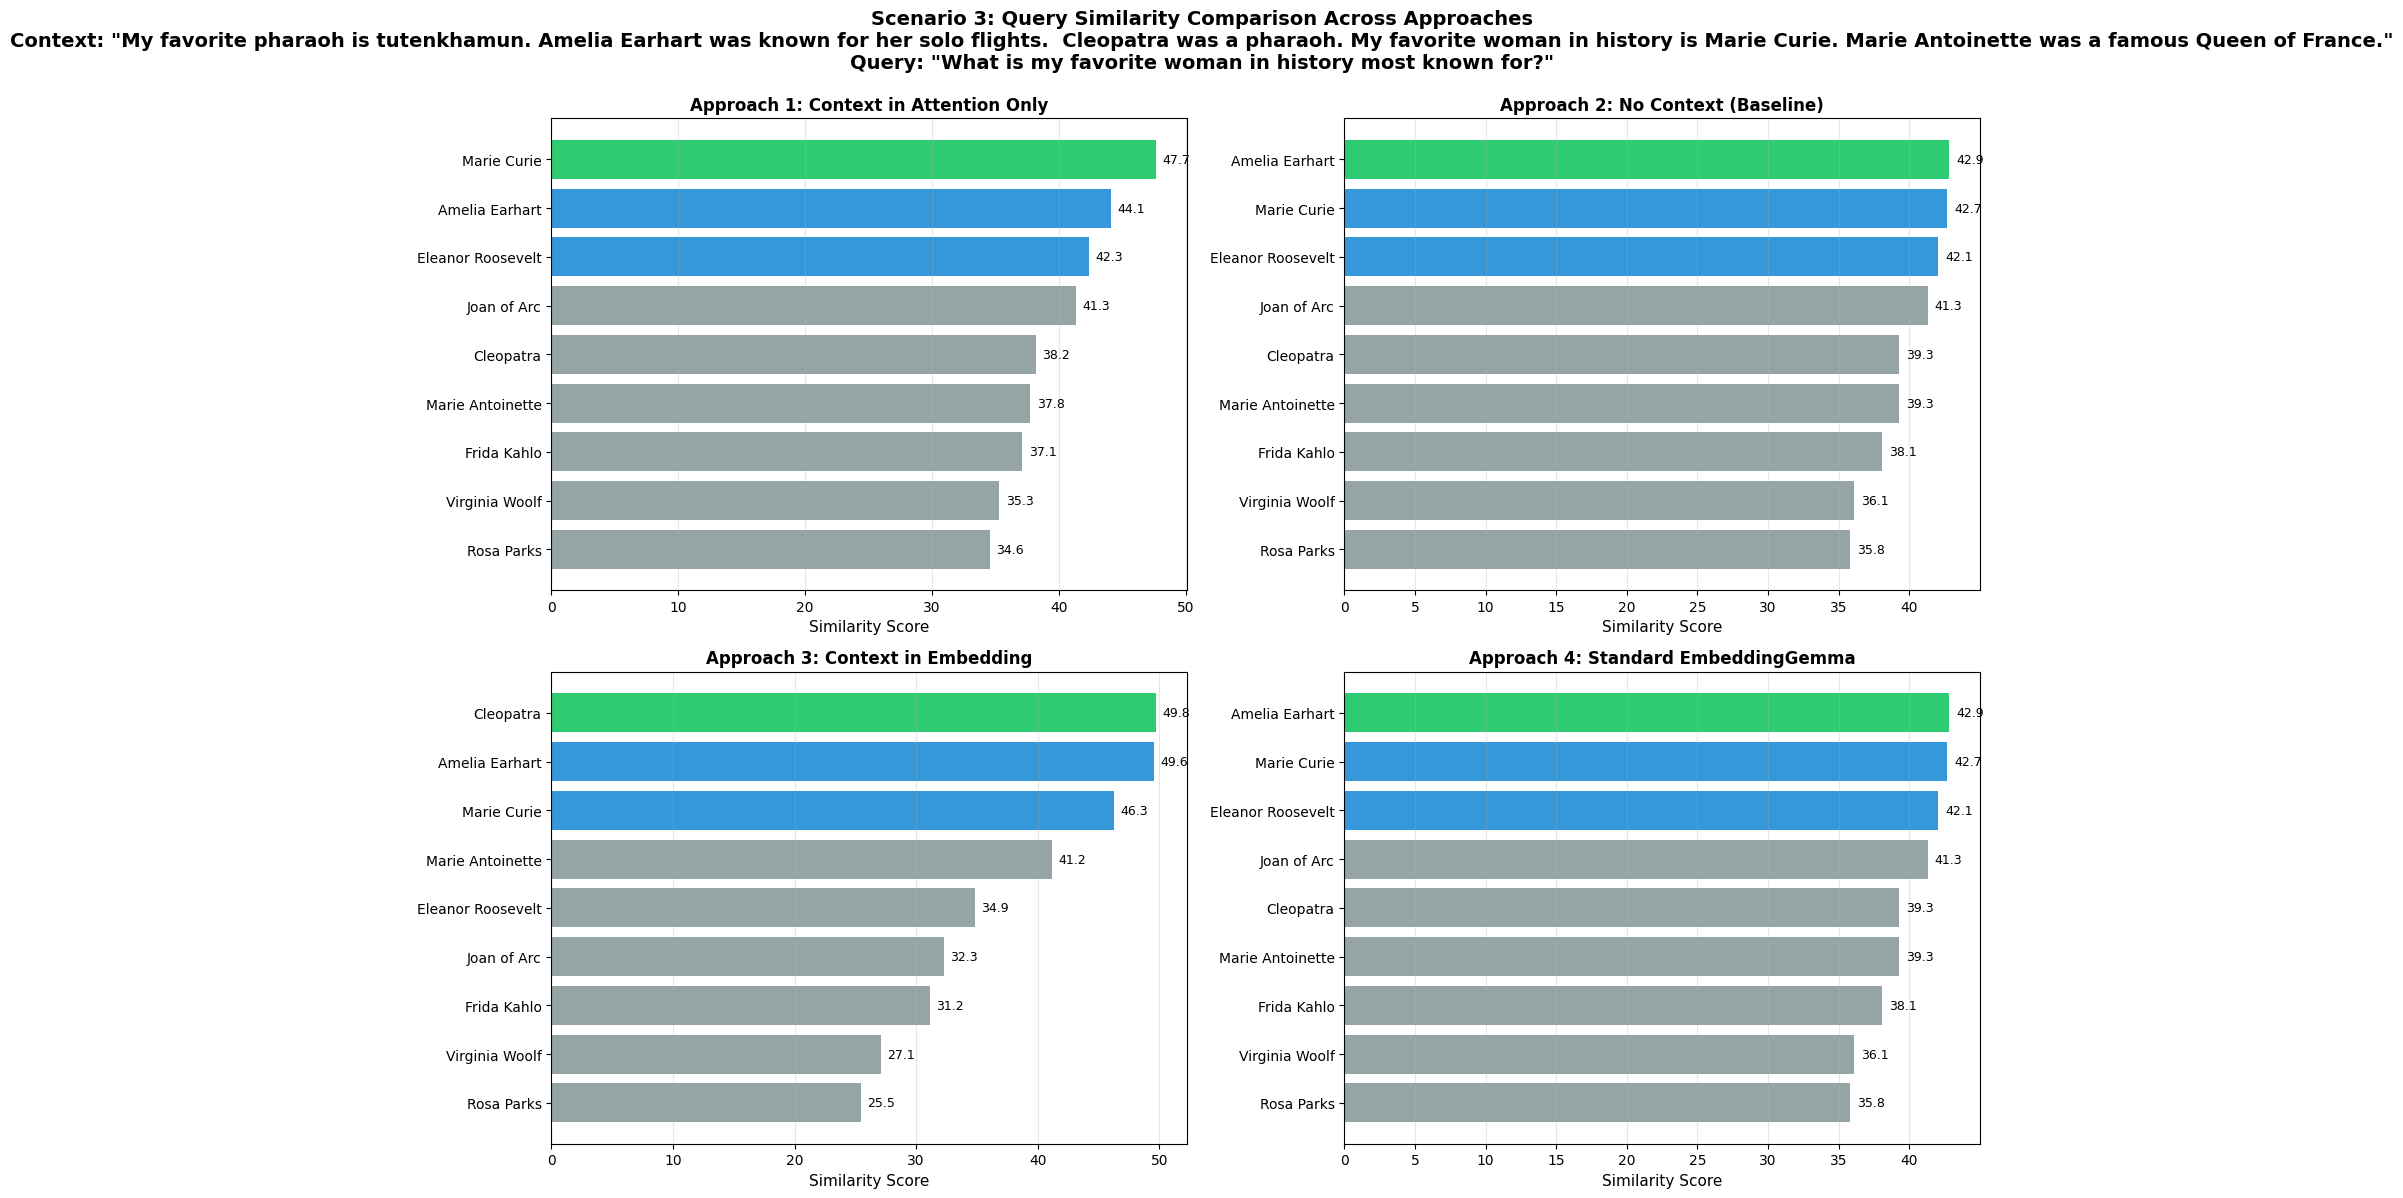


### Scenario 3: Top Match for Each Approach ###
Approach 1: Context in Attention Only:
  Winner: Marie Curie (score: 47.68)
Approach 2: No Context (Baseline):
  Winner: Amelia Earhart (score: 42.86)
Approach 3: Context in Embedding:
  Winner: Cleopatra (score: 49.77)
Approach 4: Standard EmbeddingGemma:
  Winner: Amelia Earhart (score: 42.86)



In [13]:
#########################################
# Visualize Results for All Scenarios
#########################################
print("\n\n### Visualizing Results for All Scenarios ###")

# Extract passage names (first few words for labels)
passage_labels = [p.split(' is most known')[0] for p in passages]

# Create a separate figure for each scenario
for result in all_scenario_results:
    scenario_idx = result['scenario_idx']
    context = result['context']
    query = result['query']
    all_scores = result['scores']
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    # Plot each approach
    for idx, (approach_name, scores_arr) in enumerate(all_scores.items()):
        ax = axes[idx]
        
        # Sort by score for better visualization
        sorted_indices = np.argsort(scores_arr)[::-1]
        sorted_scores = scores_arr[sorted_indices]
        sorted_labels = [passage_labels[i] for i in sorted_indices]
        
        # Create bar plot
        colors = ['#2ecc71' if i == 0 else '#3498db' if i < 3 else '#95a5a6' for i in range(len(sorted_scores))]
        bars = ax.barh(range(len(sorted_scores)), sorted_scores, color=colors)
        
        # Customize
        ax.set_yticks(range(len(sorted_scores)))
        ax.set_yticklabels(sorted_labels, fontsize=10)
        ax.set_xlabel('Similarity Score', fontsize=11)
        ax.set_title(approach_name, fontsize=12, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add score labels on bars
        for i, (bar, score) in enumerate(zip(bars, sorted_scores)):
            ax.text(score + 0.5, i, f'{score:.1f}', va='center', fontsize=9)
        
        # Invert y-axis so highest score is at top
        ax.invert_yaxis()

    plt.suptitle(f'Scenario {scenario_idx + 1}: Query Similarity Comparison Across Approaches\nContext: "{context}"\nQuery: "{query}"', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    # Print summary comparison for this scenario
    print(f"\n### Scenario {scenario_idx + 1}: Top Match for Each Approach ###")
    for approach_name, scores_arr in all_scores.items():
        top_idx = np.argmax(scores_arr)
        print(f"{approach_name}:")
        print(f"  Winner: {passage_labels[top_idx]} (score: {scores_arr[top_idx]:.2f})")
    print()
